# Multi-step joining of monthly Sentinel-2 data with points of interest for training and application of a Random-Forest model

## 0. Introduction

This notebook demonstrates how to use the Geo Engine to process raster and vector data to to train an external Random-Forest model for field-use classification.
The generation of the training data is dnoe in the Geo Engine.
The model is trained using sklearn in this notebook.
Then, the model is applied to Sentinel-2 data queried from the Geo Engine.

### Use-Case

Spatial information of field-use is very important for various applications like yield estimation.
Using Earth Observation (EO) data we can generate large raster maps of crop type or field-use.
In this notebook, we want to generate such a map for an area in the state of North Rhine-Westphalia (NRW), Germany.
To generate such a map, we need ground truth data, e.g. sampling points where the real field-use is known.
Then, we can train a Maschine Learning (ML) modell on the sample points and the corresponding values of the EO data.
The trained model can then be applied to the whole area to generate a map of the field-use.

### Data

In this notebook, we use the following data:

#### EuroCrops (NRW, Germany)

As label data (ground truth) we use the EuroCrops data for NRW, Germany.
It is available under the [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).
The data can be downloaded from [here](https://github.com/maja601/EuroCrops#vectordata_zenodo).
This dataset contains field polygons with different classes e.g. the crop type or the usage of the field.
For the demo presented in this notebook, we convert the field polygons into points and use them as sample-points.

#### Sentinel-2

The Sentinel-2 data we use is available from the Element 84 Sentinel-2 L2A Data Hub.
Using the STAC API, it can be queried for areas and times of interest.
The data is available under the [ESA Data License](https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice).
The Geo Engine provides an [ExternalDataProvider] that acts as a STAC API client that can be used to query the data.

### Workflow of this notebook

This notebook focuses on the extraction of the Sentinel-2 data for the points of interest and the model training :
1. Setup of packages, the Geo Engnie session and the area of interest.
2. Download the Sentinel-2 data for the area of interest and store it as a new (local) dataset.
3. Build the workflow for cloud-free monthly means of Sentinel-2 data and derive the NDVI.
4. Attach the aggregated Sentinel-2 to the points of interest.
5. Train a Random-Forest model to classify the field usage based on the Sentinel-2 data attached to the points.
6. Apply the model to Sentinel-2 data queried from the Geo Engine.


## 1. Setup


This notebook requires the following packages:

In [7]:
from datetime import datetime
import asyncio
import geopandas as gpd
import geoengine as ge
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from asyncstdlib.itertools import zip_longest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier


Connect to a Geo Engine instance. You need to provide user credentials via parameters or environment variables.

In [8]:
ge.initialize("http://localhost:3030/api")

In [9]:
session = ge.get_session()
user_id = session.user_id
session

Server:              http://localhost:3030/api
User Id:             d5328854-6190-4af9-ad69-4e74b0961ac9
Session Id:          d4cf3e32-a904-4481-b93f-b00e27a7475a
Session valid until: 2024-04-04T14:04:57.191Z

Set the area of interest. It is defined as a bounding box in UTM 32 N (EPSG:32632).
It is locted in NRW, Germany and covers the area between Willingen, Lippstadt and Werl.

In [10]:
[xmin, ymin, xmax, ymax] = [421395,  5681078, 476201, 5727833]
size_x = xmax - xmin
size_y = ymax - ymin
print(size_x, size_y)
(xmin, ymin, xmax, ymax)

54806 46755


(421395, 5681078, 476201, 5727833)

Using the bounding box, a time interval and a resolution, we define the area of interest as a temporal raster space-time cube.
The time interval is defined as a start and end date.
Since the field data is available for the year 2018, we use this year as the time interval.
The Sentinel-2 data has a resolution of 10 m, so we use this resolution for the area of interest as well.

In [11]:
time_start = datetime(2021, 1, 1)
time_end = datetime(2022, 1, 1)

study_area = ge.api.RasterQueryRectangle(
    spatialBounds=ge.SpatialPartition2D(xmin, ymin, xmax, ymax).to_api_dict(),
    timeInterval=ge.TimeInterval(time_start, time_end).to_api_dict(),
    spatialResolution=ge.SpatialResolution(10.0, 10.0).to_api_dict(),
)
study_area

RasterQueryRectangle(spatial_bounds=SpatialPartition2D(lower_right_coordinate=Coordinate2D(x=476201, y=5681078), upper_left_coordinate=Coordinate2D(x=421395, y=5727833)), spatial_resolution=SpatialResolution(x=10.0, y=10.0), time_interval=TimeInterval(end=1640995200000, start=1609459200000))

## 2. Download Sentinel-2 data and store it in the Geo Engine

The Sentinel-2 data is stored in the cloud (AWS S3).
There is a STAC API that provides access to the data. 
To use the data in the Geo Engine, we create workflows that accesses the different Sentinel-2 bands and make them available.
This first kind of workflow only queries the data in the area of interest and stores it as local datasets.
This way, we don't need to download the data every time we use it.

For each band (B02, B03, B04, B08) as well as the scene mask (SCL), we create a workflow using the `sentinel2_band(band_name)` blueprint.
This convenience method creates a workflow that uses the [`GdalSource`](https://docs.geoengine.io/operators/gdalsource.html) to load the Sentinel-2 data.
A source operator like the `GdalSource` takes a `DatasetId` that identifies the data to load.
In this case, the `DatasetId` is provided by an external dataset provider, that resolves band "names" to the information how to load the data from STAC / S3.
Using the `save_as_dataset(study_area)` method, we tell the Geo Engine to store the data as a new dataset.
The new dataset gets a unique `DatasetId` that we can use to load the data in the next step.

In [ ]:
download_tasks = {}
s2_data_prefix = user_id+":h_sentinel2_nrw_crop_10m_"

for b in ["B02", "B03", "B04", "B08", "SCL"]:
    sentinel2_band_workflow = ge.workflow_builder.blueprints.sentinel2_band(b)
    sentinel2_band_workflow_id = ge.register_workflow(sentinel2_band_workflow)
    print(b, sentinel2_band_workflow_id, sentinel2_band_workflow_id.get_result_descriptor())
    sentinel2_band_workflow_dataset_task = sentinel2_band_workflow_id.save_as_dataset(study_area, f"{s2_data_prefix}{b}", f"Sentinel-2 NRW area 10m {b}")
    # We start the download task and turn it into a future. This way we can await all tasks at once.
    download_tasks[b] = sentinel2_band_workflow_dataset_task.as_future(print_status=False, request_interval=60)

# the asyncio.gather function awaits all tasks at once and returns the final status as a list
download_task_results = await asyncio.gather(*download_tasks.values())

download_task_results

In [12]:
## The datasets have been downloaded and have been registered with Geo Engine. We can now use them in a workflow.

## Either convert the list of download results into a dictionary with the band name as key:

# band_dataset_names = {band: task_result.info['dataset'] for band, task_result in zip(download_tasks.keys(), download_task_results)}
# band_dataset_names

## Or just use the dataset names as defined in the download step:

band_dataset_names = {
 'B02': user_id+':h_sentinel2_nrw_crop_10m_B02',
 'B03': user_id+':h_sentinel2_nrw_crop_10m_B03',
 'B04': user_id+':h_sentinel2_nrw_crop_10m_B04',
 'B08': user_id+':h_sentinel2_nrw_crop_10m_B08',
 'SCL': user_id+':h_sentinel2_nrw_crop_10m_SCL'
}

band_dataset_names

{'B02': 'd5328854-6190-4af9-ad69-4e74b0961ac9:h_sentinel2_nrw_crop_10m_B02',
 'B03': 'd5328854-6190-4af9-ad69-4e74b0961ac9:h_sentinel2_nrw_crop_10m_B03',
 'B04': 'd5328854-6190-4af9-ad69-4e74b0961ac9:h_sentinel2_nrw_crop_10m_B04',
 'B08': 'd5328854-6190-4af9-ad69-4e74b0961ac9:h_sentinel2_nrw_crop_10m_B08',
 'SCL': 'd5328854-6190-4af9-ad69-4e74b0961ac9:h_sentinel2_nrw_crop_10m_SCL'}

## 3. Monthly, cloud-free aggregations of the Sentinel-2 bands & NDVI

For the training, we use the Sentinel-2 data of the bands 02, 03, 04, and 08. The scene classification layer (SCL) is used to filter out cloudy pixels for each band using an expression. The NDVI is calculated using an expression on band 4 and 8. 


Now for each variable we want to use in the training, we create a workflow that aggregates the data to monthly, cloud-free means.
The workflow is created using the `sentinel2_cloud_free_band_custom_input` method that creates a workflow for loading data and removing clouded pixels.
This method takes the `DatasetName` of the band of interest and the name of the scene classification layer (SCL) as input.

The workflows created use the [`GdalSource`](https://docs.geoengine.io/operators/gdalsource.html) to load the band rasters and the cloud mask. Then an [`Expression`](https://docs.geoengine.io/operators/expression.html) is used to filter out pixels that are marked "cloudy" in the SCL.

The NDVI is calculated using an expression on band 4 and 8.
For convenience, there is a `sentinel2_cloud_free_ndvi_custom_input` method that takes the `DatasetName` of the bands 4, 8, and the SCL as input.
It creates a workflow that loads the data, removes cloudy pixels and calculates the NDVI using an expression.

In [13]:
cloud_free_workflows = {}

for b in ["B02", "B03", "B04", "B08"]:
    band_dataset_name = band_dataset_names[b]
    scl_dataset_name = band_dataset_names["SCL"]
    sentinel2_band_workflow = ge.workflow_builder.blueprints.sentinel2_cloud_free_band_custom_input(band_dataset=band_dataset_name, scl_dataset=scl_dataset_name)    
    cloud_free_workflows[b] = ge.workflow_builder.operators.RasterTypeConversion(source=sentinel2_band_workflow, output_data_type="F32")

ndvi_workflow = ge.workflow_builder.blueprints.sentinel2_cloud_free_ndvi_custom_input(nir_dataset=band_dataset_names["B08"], red_dataset=band_dataset_names["B04"], scl_dataset=band_dataset_names["SCL"])
cloud_free_workflows["NDVI"] = ndvi_workflow


cloud_free_workflows

{'B02': <geoengine.workflow_builder.operators.RasterTypeConversion at 0x7fd3d49ebf10>,
 'B03': <geoengine.workflow_builder.operators.RasterTypeConversion at 0x7fd3d3ee5360>,
 'B04': <geoengine.workflow_builder.operators.RasterTypeConversion at 0x7fd3d3ee4310>,
 'B08': <geoengine.workflow_builder.operators.RasterTypeConversion at 0x7fd3d3ee4f10>,
 'NDVI': <geoengine.workflow_builder.operators.Expression at 0x7fd3d3ee51e0>}

Now the bands we use are stacked to create a single workflow that provides the bands 02, 03, 04, and 08  as well as the NDVI. This step uses the RasterStacker operator to combine the workflows.

In [14]:
cloud_free_stack_workflow = ge.workflow_builder.operators.RasterStacker([wf for wf in cloud_free_workflows.values()])
cloud_free_stack_workflow

Since the Sentinel 2 data can include "holes" where clouds have been, we aggregate the NDVI and the bands 02, 03, 04, and 08 to monthy means. Since we stacked the data in the previous step, we can apply the TemporalRasterAggregation operator to the stacked workflow. The operator takes care to aggregate each band to monthly means.

In [15]:
monthly_cloud_free_stack_workflow = ge.workflow_builder.operators.TemporalRasterAggregation(
        source=cloud_free_stack_workflow,
        aggregation_type="mean",
        granularity="months",
        window_size=1,
        ignore_no_data=True,
        output_type="F32"
    )

monthly_cloud_free_stack_workflow

For the analysis of crops on fields, the temporal information is very important.
Lots of information can be gained by looking at the development of the NDVI over time.
Therefore, we want to generate for each point of interest the NDVI and other band information of the previous 8 months.
To do this, we wrap the workflow in a [`TimeShift](https://docs.geoengine.io/operators/timeshift.html) operator.
This way, we can use the existing workflow and just shift the temporal domain for all the months we are interested in.

In [16]:
monthly_cloud_free_workflows_shifted = {}

for month_shift in range(0,-8, -1):
    monthly_cloud_free_workflows_shifted[month_shift] = ge.workflow_builder.operators.TimeShift(granularity="months", value=month_shift, shift_type="relative", source=monthly_cloud_free_stack_workflow)
    
monthly_cloud_free_workflows_shifted


{0: <geoengine.workflow_builder.operators.TimeShift at 0x7fd3d49ebd30>,
 -1: <geoengine.workflow_builder.operators.TimeShift at 0x7fd3d49eb460>,
 -2: <geoengine.workflow_builder.operators.TimeShift at 0x7fd3d4223fd0>,
 -3: <geoengine.workflow_builder.operators.TimeShift at 0x7fd4b0546020>,
 -4: <geoengine.workflow_builder.operators.TimeShift at 0x7fd4b05472e0>,
 -5: <geoengine.workflow_builder.operators.TimeShift at 0x7fd4b04a6950>,
 -6: <geoengine.workflow_builder.operators.TimeShift at 0x7fd4b04a65c0>,
 -7: <geoengine.workflow_builder.operators.TimeShift at 0x7fd4b04a6e00>}

Now we have 8 workflows that provide the shifted monthly data. Using the RasterStacker operator, we can combine the 8 workflows to a single workflow that provides 8 x 5 bands for each step in time. And since we applied the TimeShift operator this is the data of the previous 8 months for each selected time step.

In [17]:
month_timeshift_stack_workflow = ge.workflow_builder.operators.RasterStacker([wf for wf in monthly_cloud_free_workflows_shifted.values()])
month_timeshift_stack_workflow

## 4. Join the monthly Sentinel-2 data to the points of interest

This step combines the monthly aggregated Sentinel-2 data with the points of interest. The resulting dataset is then queried from directly from python and stored as a pandas dataframe.

Upload the points of interest to the Geo Engine. First we use GeoPandas to load the points of interest into a DataFrame. Then we use the `upload_dataframe` method to upload the points to the Geo Engine.

In [18]:
points_df = gpd.read_file("group_sample_frac1_inspireId_use_utm32n.gpkg")
points_dataset_name = ge.upload_dataframe(points_df, "group_sample_frac1_inspireId")
points_dataset_name

d5328854-6190-4af9-ad69-4e74b0961ac9:e39cc4b5-1767-4cfc-a046-e69680eca89c

To use the points in a Geo Engine workflow, we define a [`OgrSource`](https://docs.geoengine.io/operators/ogrsource.html) operator and pass the id of the uploaded points to it.

In [19]:
points_source_operator = ge.workflow_builder.operators.OgrSource(points_dataset_name)
points_source_operator.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'OgrSource',
  'params': {'data': 'd5328854-6190-4af9-ad69-4e74b0961ac9:e39cc4b5-1767-4cfc-a046-e69680eca89c',
   'attributeProjection': None,
   'attributeFilters': None}}}

Now, we create a workflow that uses [`RasterVectorJoin`](https://docs.geoengine.io/operators/rastervectorjoin.html) operator to join prepared Sentinel-2 data to the points. This operator creates a new column for each band and adds the value of the raster pixel that is closest to each point. The points are provided as input by the [`OgrSource`](https://docs.geoengine.io/operators/ogrsource.html). Additionally the [`RasterVectorJoin`](https://docs.geoengine.io/operators/rastervectorjoin.html) takes a raster input. Here we use the already defined workflow that provides the monthly, cloud-free means of the Sentinel-2 bands and NDVI. 






In [20]:
# TODO: the stacker should be able to take band / input prefixes
# band_names = list(cloud_free_workflows.keys()) 
# month_band_names = [f"{b}_{month_shift}" for month_shift in range(0,-8, -1) for b in band_names ]
# month_band_names

points_with_s2_cloud_free_shift = ge.workflow_builder.operators.RasterVectorJoin(
    raster_sources=[month_timeshift_stack_workflow],
    vector_source=points_source_operator, #projected_points,
    new_column_names=["x"],
)
       
points_with_s2_cloud_free_shift.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'RasterVectorJoin',
  'params': {'names': ['x'],
   'temporalAggregation': 'none',
   'temporalAggregationIgnoreNoData': False,
   'featureAggregation': 'mean',
   'featureAggregationIgnoreNoData': False},
  'sources': {'vector': {'type': 'OgrSource',
    'params': {'data': 'd5328854-6190-4af9-ad69-4e74b0961ac9:e39cc4b5-1767-4cfc-a046-e69680eca89c',
     'attributeProjection': None,
     'attributeFilters': None}},
   'rasters': [{'type': 'RasterStacker',
     'params': {},
     'sources': {'rasters': [{'type': 'TimeShift',
        'params': {'type': 'relative', 'granularity': 'months', 'value': 0},
        'sources': {'source': {'type': 'TemporalRasterAggregation',
          'params': {'aggregation': {'type': 'mean', 'ignoreNoData': True},
           'window': {'granularity': 'months', 'step': 1},
           'outputType': 'F32'},
          'sources': {'raster': {'type': 'RasterStacker',
            'params': {},
            'sources': {'rasters

Now we can register the workflow at the Geo Engine:

In [21]:
workflow = ge.register_workflow(points_with_s2_cloud_free_shift)
workflow

bda5ed23-b9d8-5ccd-86d0-4bcc7ca080b2

The `ResultDescriptor` of the workflow is a `VectorResultDescriptor`.
It includes the description of all the columns that are created by the workflow.

In [22]:
workflow.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:32632
Columns:
  x_23:
    Column Type: float
    Measurement: unitless
  x_7:
    Column Type: float
    Measurement: unitless
  x_37:
    Column Type: float
    Measurement: unitless
  x_17:
    Column Type: float
    Measurement: unitless
  x_31:
    Column Type: float
    Measurement: unitless
  x_25:
    Column Type: float
    Measurement: unitless
  x_19:
    Column Type: float
    Measurement: unitless
  x_29:
    Column Type: float
    Measurement: unitless
  x_26:
    Column Type: float
    Measurement: unitless
  x_2:
    Column Type: float
    Measurement: unitless
  index:
    Column Type: int
    Measurement: unitless
  x_11:
    Column Type: float
    Measurement: unitless
  x_8:
    Column Type: float
    Measurement: unitless
  x_13:
    Column Type: float
    Measurement: unitless
  x_27:
    Column Type: float
    Measurement: unitless
  x_14:
    Column Type: float
    Measurement: unitless
  x_30:
    Column Type

To query the workflow we need datetime objects for the start and end of the time interval we are interested in.
Since the `TimeShift` operator takes care to generate 8 previous months, we need only need to query the last month of the time interval.

In [23]:
start_dt = datetime(2021, 10, 1, 0, 0, 0)
end_dt = start_dt

start_dt, end_dt

(datetime.datetime(2021, 10, 1, 0, 0), datetime.datetime(2021, 10, 1, 0, 0))

Now, we query the workflow that attaches the Sentinel-2 data for the area of interest.
We use a resolution of 10m, which is the native resolution if the Sentinel-2 bands.
The workflow result is transformed into a pandas dataframe automatically.

In [24]:
gp_res = await workflow.vector_stream_into_geopandas(
    ge.QueryRectangle(
        spatial_bounds=ge.BoundingBox2D(
            xmin=xmin,
            ymin=ymin,
            xmax=xmax,
            ymax=ymax,
        ),
        time_interval=ge.TimeInterval(
            start=start_dt,
            end=end_dt,
        ),
        resolution=ge.SpatialResolution(
            10.0,
            10.0,
        ),
        srs="EPSG:32632",
))

# gp_res.to_file("gp_res_100_frac1_monthly_use_utm32n_multi_steps_8months_shift_stack.gpkg", driver="GPKG")
gp_res

ID   index                                         INSPIRE_ID  \
0          0       0  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
1          1       1  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
2          2       2  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
3          3     265  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
4          4     266  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
...      ...     ...                                                ...   
49419  49419  732423  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
49420  49420  732424  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
49421  49421  732425  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
49422  49422  732426  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
49423  49423  732802  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   

      USE_CODE        USE_TXT           x          x_1          x_2  \
0           OE       Ölsaaten  603.000000   906.500000  1174.500000   
1           GT       Getreide  719.333313   970.166687   703.666687   
2           GT       Getreide  750.400024  1082.000000  1261.599976   
3           GL  Dauergrünland  198.375000   299.250000   245.375000   
4           GL  Dauergrünland  521.400024   718.799988   521.200012   
...        ...            ...         ...          ...          ...   
49419       GT       Getreide  482.777771   780.888916   794.666687   
49420       GT       Getreide  244.285721   457.428558   379.428558   
49421       GT       Getreide  461.000000   777.181824   785.545471   
49422       AF    Ackerfutter  279.000000   521.142883   369.285706   
49423       GL  Dauergrünland  292.399994   701.200012   314.600006   

               x_3       x_4  ...         x_33      x_34         x_35  \
0      1831.750000  0.146847  ...  4119.333496  0.403594   495.000000   
1      3555.000000  0.400657  ...  3597.000000  0.380573   487.666656   
2      2065.800049  0.182716  ...  2595.333252  0.284567   501.500000   
3      1268.875000  0.393650  ...  1732.400024  0.218832   279.333344   
4      3661.300049  0.381649  ...  2462.714355  0.240958   392.000000   
...            ...       ...  ...          ...       ...          ...   
49419  2705.444336  0.270196  ...  3194.666748  0.234521   561.000000   
49420  3851.857178  0.322308  ...  1822.000000  0.128668   858.000000   
49421  2457.545410  0.251394  ...  2938.714355  0.346857   612.500000   
49422  4185.571289  0.283557  ...  1422.250000  0.122962  1404.000000   
49423  5036.600098  0.381780  ...  4889.333496  0.377710   799.000000   

              x_36         x_37         x_38      x_39  \
0       764.000000   495.000000  4922.000000  0.267085   
1       785.333313   559.333313  3118.666748  0.321335   
2       702.750000   482.000000  2908.000000  0.322065   
3       377.333344   439.000000  1200.000000  0.113144   
4       650.666687   745.333313  2744.666748  0.168344   
...            ...          ...          ...       ...   
49419   793.000000   787.666687  2748.666748  0.142224   
49420  1228.000000  1556.000000  2452.000000  0.099950   
49421   962.000000  1013.500000  2870.000000  0.118178   
49422  1640.500000  1864.000000  3060.500000  0.111439   
49423  1085.666626   958.666687  4033.000000  0.214367   

                                  geometry                time_start  \
0      MULTIPOINT (428690.027 5711938.189) 2021-10-01 00:00:00+00:00   
1      MULTIPOINT (427819.337 5710040.545) 2021-10-01 00:00:00+00:00   
2      MULTIPOINT (427320.866 5710158.178) 2021-10-01 00:00:00+00:00   
3      MULTIPOINT (431527.388 5693772.886) 2021-10-01 00:00:00+00:00   
4      MULTIPOINT (431535.193 5693614.690) 2021-10-01 00:00:00+00:00   
...                                    ...                       ...   
49419  MULTIPOINT (472357.075 5696612.529) 2021-10-01 00:00:00+00:00   
49420  MULTIPOINT (472016.875 5697690.039) 2021-10-01 00:00:00+00:00   
49421  MULTIPOINT (471981.413 5696

## 5. Train a Random-Forest on the monthly Sentinel-2 data and the NRW crop data

Now we can train a Random-Forest on the monthly Sentinel-2 data and the NRW crop data. We use the `sklearn` package for this. But first, we need to prepare the data.

First, we need to replace the nan values in the dataframe with a number that is not part of the dataset. For this example we use 0.
This is necessary since the sklearn RF does not support nan values.

In [25]:
gp_train_1=gp_res.replace(np.nan, 0)
gp_train_1

ID   index                                         INSPIRE_ID  \
0          0       0  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
1          1       1  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
2          2       2  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
3          3     265  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
4          4     266  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
...      ...     ...                                                ...   
49419  49419  732423  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
49420  49420  732424  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
49421  49421  732425  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
49422  49422  732426  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   
49423  49423  732802  https://geodaten.nrw.de/id/inspire-lu-ts/exist...   

      USE_CODE        USE_TXT           x          x_1          x_2  \
0           OE       Ölsaaten  603.000000   906.500000  1174.500000   
1           GT       Getreide  719.333313   970.166687   703.666687   
2           GT       Getreide  750.400024  1082.000000  1261.599976   
3           GL  Dauergrünland  198.375000   299.250000   245.375000   
4           GL  Dauergrünland  521.400024   718.799988   521.200012   
...        ...            ...         ...          ...          ...   
49419       GT       Getreide  482.777771   780.888916   794.666687   
49420       GT       Getreide  244.285721   457.428558   379.428558   
49421       GT       Getreide  461.000000   777.181824   785.545471   
49422       AF    Ackerfutter  279.000000   521.142883   369.285706   
49423       GL  Dauergrünland  292.399994   701.200012   314.600006   

               x_3       x_4  ...         x_33      x_34         x_35  \
0      1831.750000  0.146847  ...  4119.333496  0.403594   495.000000   
1      3555.000000  0.400657  ...  3597.000000  0.380573   487.666656   
2      2065.800049  0.182716  ...  2595.333252  0.284567   501.500000   
3      1268.875000  0.393650  ...  1732.400024  0.218832   279.333344   
4      3661.300049  0.381649  ...  2462.714355  0.240958   392.000000   
...            ...       ...  ...          ...       ...          ...   
49419  2705.444336  0.270196  ...  3194.666748  0.234521   561.000000   
49420  3851.857178  0.322308  ...  1822.000000  0.128668   858.000000   
49421  2457.545410  0.251394  ...  2938.714355  0.346857   612.500000   
49422  4185.571289  0.283557  ...  1422.250000  0.122962  1404.000000   
49423  5036.600098  0.381780  ...  4889.333496  0.377710   799.000000   

              x_36         x_37         x_38      x_39  \
0       764.000000   495.000000  4922.000000  0.267085   
1       785.333313   559.333313  3118.666748  0.321335   
2       702.750000   482.000000  2908.000000  0.322065   
3       377.333344   439.000000  1200.000000  0.113144   
4       650.666687   745.333313  2744.666748  0.168344   
...            ...          ...          ...       ...   
49419   793.000000   787.666687  2748.666748  0.142224   
49420  1228.000000  1556.000000  2452.000000  0.099950   
49421   962.000000  1013.500000  2870.000000  0.118178   
49422  1640.500000  1864.000000  3060.500000  0.111439   
49423  1085.666626   958.666687  4033.000000  0.214367   

                                  geometry                time_start  \
0      MULTIPOINT (428690.027 5711938.189) 2021-10-01 00:00:00+00:00   
1      MULTIPOINT (427819.337 5710040.545) 2021-10-01 00:00:00+00:00   
2      MULTIPOINT (427320.866 5710158.178) 2021-10-01 00:00:00+00:00   
3      MULTIPOINT (431527.388 5693772.886) 2021-10-01 00:00:00+00:00   
4      MULTIPOINT (431535.193 5693614.690) 2021-10-01 00:00:00+00:00   
...                                    ...                       ...   
49419  MULTIPOINT (472357.075 5696612.529) 2021-10-01 00:00:00+00:00   
49420  MULTIPOINT (472016.875 5697690.039) 2021-10-01 00:00:00+00:00   
49421  MULTIPOINT (471981.413 5696

Now we create the training input.
This also makes sure that the data is in the correct order when we train the RF.

In [26]:
# TODO: go back to the "real" band names
# train_variable_order = ['B02_0', 'B02_-1', 'B02_-2', 'B02_-3', 'B02_-4',  'B02_-5',  'B02_-6', 'B02_-7', 'B02_-8',
#        'B03_0', 'B03_-1', 'B03_-2', 'B03_-3', 'B03_-4',  'B03_-5',  'B03_-6', 'B03_-7', 'B03_-8',
#        'B04_0', 'B04_-1', 'B04_-2', 'B04_-3', 'B04_-4',  'B04_-5',  'B04_-6', 'B04_-7', 'B04_-8',
#        'B08_0', 'B08_-1', 'B08_-2', 'B08_-3', 'B08_-4',  'B08_-5',  'B08_-6', 'B08_-7', 'B08_-8',
#        'NDVI_0', 'NDVI_-1', 'NDVI_-2', 'NDVI_-3', 'NDVI_-4',  'NDVI_-5',  'NDVI_-6', 'NDVI_-7', 'NDVI_-8']
train_variable_order = ['x', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39']

x_list = gp_train_1[train_variable_order].values

The labels are stored in the column `USE_CODE`. 

In [27]:
y_list = gp_train_1['USE_CODE'].replace(0, 'None')
y_list

0        OE
1        GT
2        GT
3        GL
4        GL
         ..
49419    GT
49420    GT
49421    GT
49422    AF
49423    GL
Name: USE_CODE, Length: 49424, dtype: object

First, we create a train-test split. We use 80% of the data for training and 20% for testing.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.2, random_state=31337, stratify=y_list)

Then, we train the RF on the training data:

In [29]:
X = X_train
Y = y_train
clf = RandomForestClassifier(random_state=1337, class_weight='balanced_subsample', n_estimators=300)
clf = clf.fit(X, Y)
str(clf)

"RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,\n                       random_state=1337)"

We can then create a report of the trained RF:

In [30]:
x_test_predictions = clf.predict(X_test)

print(classification_report(y_test, x_test_predictions, labels=clf.classes_, zero_division=0, digits=3))

              precision    recall  f1-score   support

          AF      0.671     0.682     0.676      1048
          DA      0.667     0.031     0.059        65
          EP      0.000     0.000     0.000        14
          EW      0.819     0.527     0.642       146
          GL      0.788     0.979     0.873      3919
          GM      0.533     0.205     0.296        39
          GT      0.858     0.888     0.873      2794
          HF      0.752     0.868     0.806       220
          HP      0.000     0.000     0.000         0
        None      0.000     0.000     0.000       108
          OE      0.908     0.866     0.886       284
          PA      0.000     0.000     0.000       238
          SF      0.357     0.032     0.059       156
          SL      0.616     0.294     0.398       847
          ZP      1.000     0.143     0.250         7

   micro avg      0.790     0.790     0.790      9885
   macro avg      0.531     0.368     0.388      9885
weighted avg      0.747   

Print the confusion matrix:

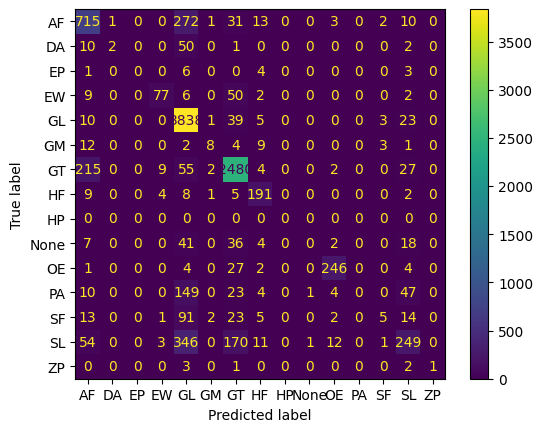

In [31]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

The confusion matrix shows that the class distribution is very imbalanced.
This is why the accuracy is so high.
The model is very good at predicting the most common classes.
This is also visible in the precision and recall scores in the classification report.
The precision and recall scores are very high for the most common classes and low for the less common classes. 
However the F1 score is still high.
To imporve the model, we can train on a larger dataset that contains more samples of the less common classes.
For this example, we are fine with using the trained RF as is.

## 6. Apply the trained Random-Forest to the monthly Sentinel-2 data

To generate a raster map of the field-use classes, we can apply the trained RF to the Sentinel-2 data.
For this we can use the workflow that generates the monthly Sentinel-2 data. This time we use it to apply the trained RF to all the pixels.
To do this, we query raster tiles from the Geo Engine and apply the RF to all pixels in each raster tile.

Normally we would retrain the model on all data, but for demonstration and simplicity we use the model trained on the train/test split.

Now we specify the query rectangle we are interested in. It is a subeset of the area of interest defined in step 2.

In [32]:
start_dt = datetime(2021, 10, 15, 0, 0, 0)
end_dt = datetime(2021, 10, 15, 0, 0, 0)

box_size = 512

box_center_x = 0.5 * (xmin + xmax)
box_center_y = 0.5 * (ymin + ymax)

box_x_min = box_center_x - box_size *10
box_x_max = box_center_x + box_size *10
box_y_min = box_center_y - box_size *10
box_y_max = box_center_y + box_size *10

query_rect = ge.QueryRectangle(
        spatial_bounds=ge.BoundingBox2D(
            xmin=box_x_min,
            ymin=box_y_min,
            xmax=box_x_max,
            ymax=box_y_max,
        ),
        time_interval=ge.TimeInterval(
            start=start_dt,
            end=end_dt,
        ),
        resolution=ge.SpatialResolution(
            10.0,
            10.0,
        ),
        srs="EPSG:32632",
)

query_rect

QueryRectangle( 
    BoundingBox2D(xmin=443678.0, ymin=5699335.5, xmax=453918.0, ymax=5709575.5)
    TimeInterval(start=2021-10-15T00:00:00.000000, end=2021-10-15T00:00:00.000000)
    SpatialResolution(x=10.0, y=10.0)
    srs=EPSG:32632 
)

We also need a map from category to number. This is necessary since the RF produces class names and we want to store the result as a raster dataset.

In [33]:
code_id_map = {
    'None': 0,
    'AF': 1,
    'DA': 2,
    'EP': 3,
    'EW': 4,
    'GL': 5,
    'GM': 6,
    'GT': 7,
    'HF': 8,
    'HP': 9,
    'OE': 10,
    'PA': 11,
    'SF': 12,
    'SL': 13,
    'ZP': 14,    
}

id_code_map = {v: k for k, v in code_id_map.items()}


Now we query the workflow and create a raster stream. The raster stream provides an (async) iterator that produces `RasterTile2D`. A `RasterTile2D` includes a (masked) numpy array as well as other information for each band and tile. To make life easier, we use the provided `tile_stream_to_np_stack` method to convert the raster stream of band tiles into an (async) iterator of `RasterTileStack2D` hat includes all bands for each tile.
For each tile (list) we apply the RF to the data and store the result as a new tile. The result is a list of tiles, where each tile contains the predicted crop class for one pixel.

In [34]:
# register the data workflow
raster_tile_workflow = ge.register_workflow(month_timeshift_stack_workflow)
result_descriptor = raster_tile_workflow.get_result_descriptor()

# get the band indices
bands = list(range(0, len(result_descriptor.bands)))

# create the raster stream
raster_stream = raster_tile_workflow.raster_stream(query_rect, bands=bands)

# to make it easier to work with the data, we stack all the bands of each tile into 3D numpy arrays
stacked_tiles_stream = ge.raster.tile_stream_to_np_stack(raster_stream)

# create storeage for the results
res_arrays = []
rgb_arrays = []

    
# iterate over the stacks of tiles 
async for tile_stack in stacked_tiles_stream:
    
    # convert the stack to a 3D numpy array
    tile_arr = tile_stack.to_numpy_masked_array_stack()    
    
    # get the shape of the data
    (num_bands, num_y, num_x) = tile_arr.data.shape
    
    # prepare masked data and reshape it into a 2D array for the classifier    
    a = tile_arr.data
    if np.ma.isMaskedArray(a):
        a = tile_arr.data.filled(fill_value=0.) # no-data is represented by masked arrays, we will these pixels with 0

    np.nan_to_num(a, copy=False, nan=0) # this should not be necessarry since we get masked arrays and fill the masked values with 0
    b = np.moveaxis(a, 0, -1) # move the band axis to the last axis, so we can put slices into the classifier
    c = b.reshape((num_x * num_y, num_bands)) # reshape the data into a 2D array
    
     # apply the classifier to the data    
    pred_classes = clf.predict(c)
    pred_numbers = np.vectorize(code_id_map.get)(pred_classes)
    
    # reshape the result back into a 2D array
    res_array = pred_numbers.reshape((num_y, num_x))
    
    # append the result to the list of results
    res_arrays.append(res_array)

    # add rgb data to the list of rgb arrays
    rgb = tile_arr.data[0:3, :, :]
    rgb = np.flip(rgb, axis=0)
    min = np.min(rgb, axis=(1, 2), keepdims=True)
    max = np.max(rgb, axis=(1, 2), keepdims=True)
    rgb = (rgb - min) / (max - min)
    
    rgb = np.moveaxis(rgb, 0, -1)
    
    rgb_arrays.append(rgb)

    
res_arrays
    

0 -1
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0

[array([[ 5, 13,  7, ...,  8,  8,  8],
        [ 5,  7,  7, ...,  8,  8,  8],
        [ 5,  7,  7, ...,  8,  8,  8],
        ...,
        [ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7],
        [ 7,  7,  7, ...,  7,  7,  7]]),
 array([[8, 8, 8, ..., 1, 1, 1],
        [8, 8, 8, ..., 1, 1, 1],
        [8, 8, 8, ..., 1, 1, 1],
        ...,
        [7, 7, 7, ..., 5, 5, 5],
        [7, 7, 7, ..., 5, 5, 5],
        [7, 7, 7, ..., 5, 5, 5]]),
 array([[ 1,  1,  1, ...,  5,  5,  5],
        [ 1,  1,  1, ...,  5,  5,  5],
        [ 1,  1,  1, ...,  5,  5,  5],
        ...,
        [ 5,  5,  5, ..., 10, 10, 10],
        [ 5,  5,  5, ..., 10, 10, 10],
        [ 5,  5,  5, ..., 10, 10, 10]]),
 array([[7, 7, 7, ..., 7, 7, 7],
        [7, 7, 7, ..., 7, 7, 7],
        [7, 7, 7, ..., 7, 7, 7],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]]),
 array([[7, 7, 7, ..., 5, 5, 5],
        [7, 7, 7, ..., 5, 5, 5],
        [7

We can now print the result as a image:

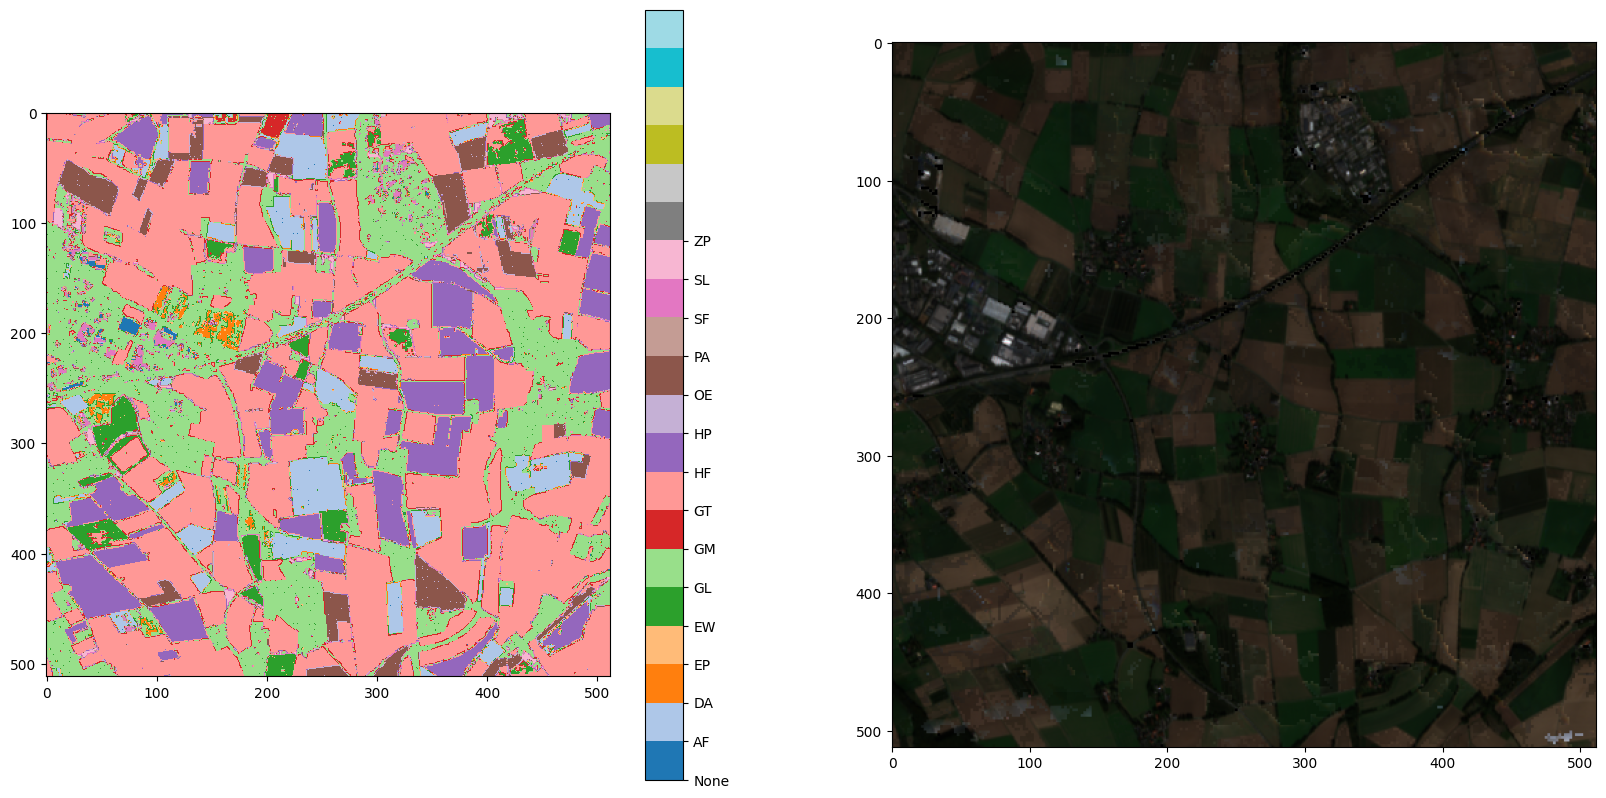

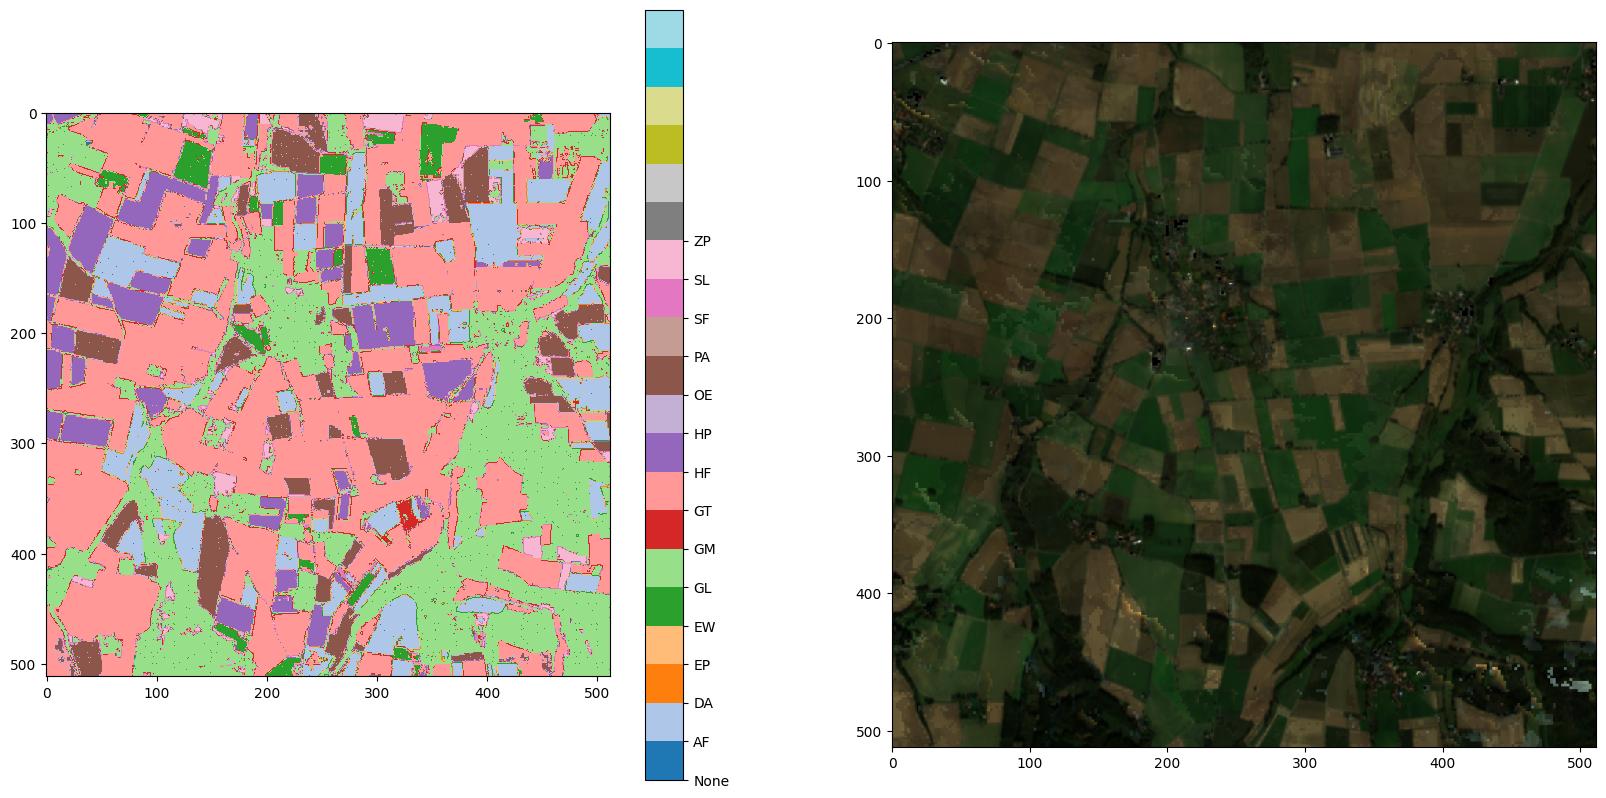

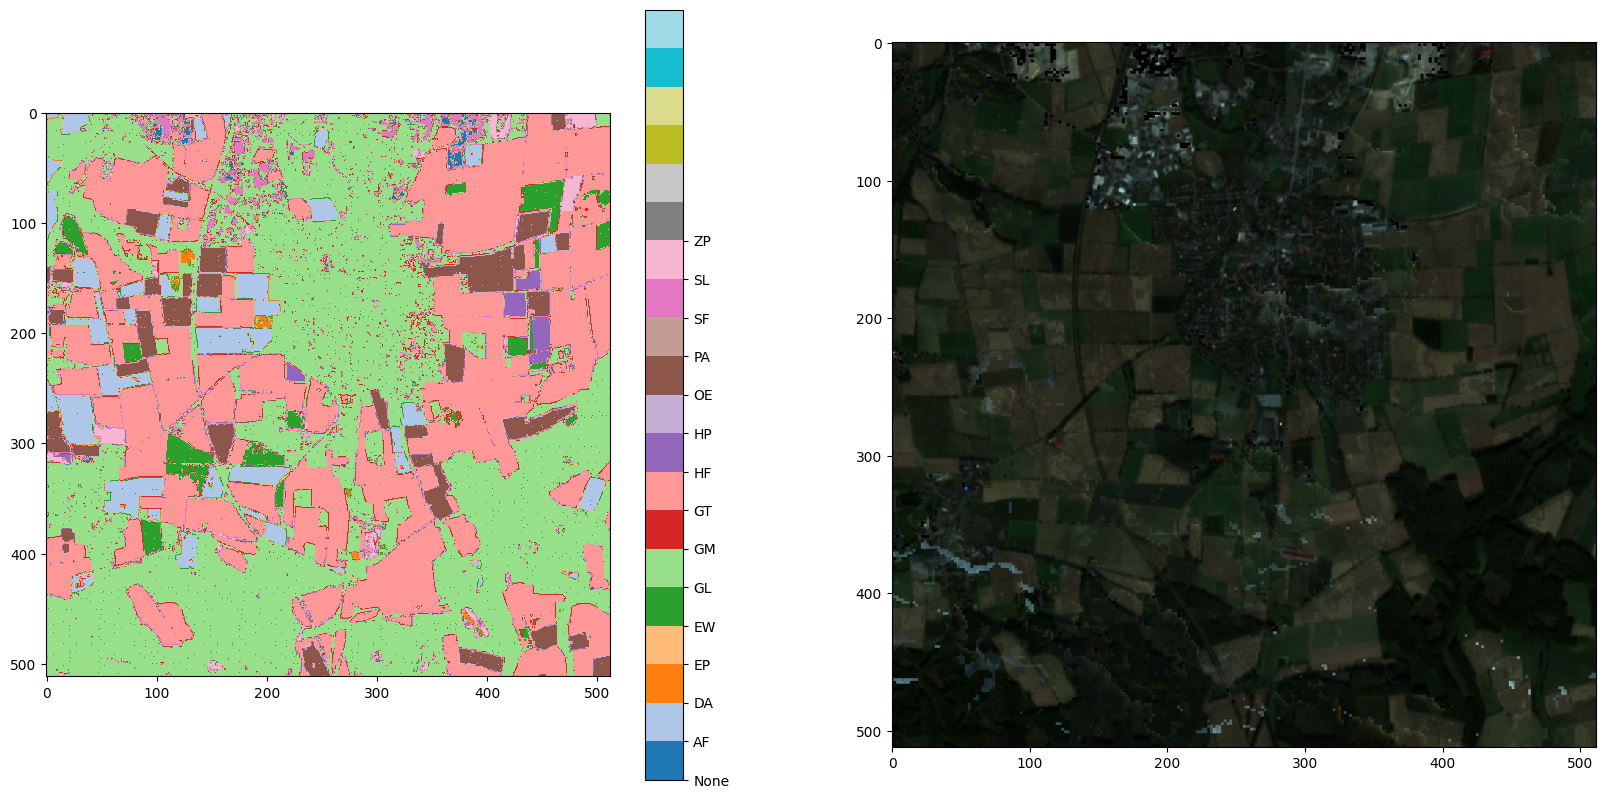

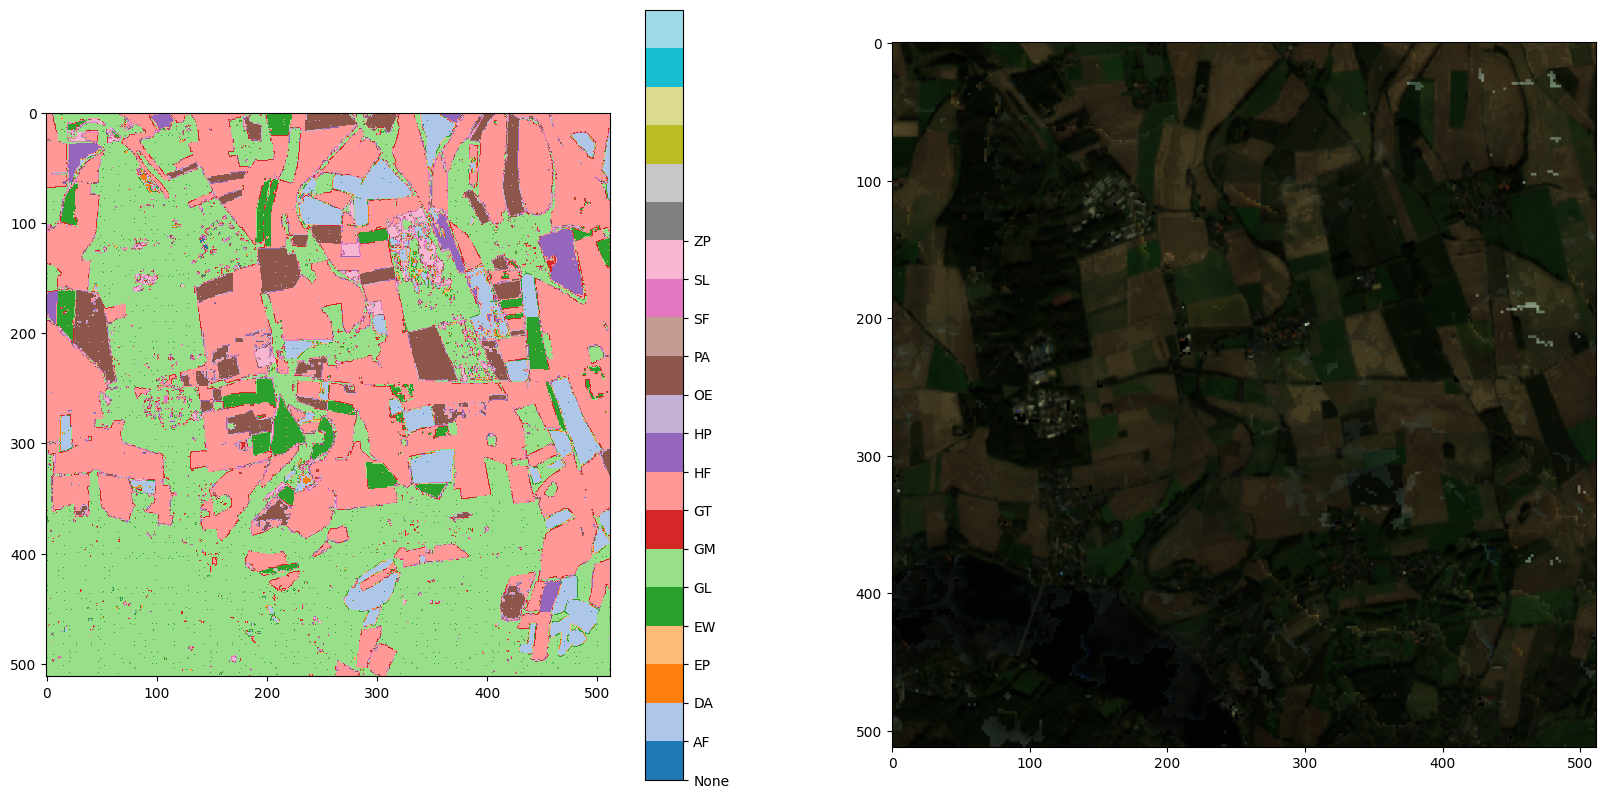

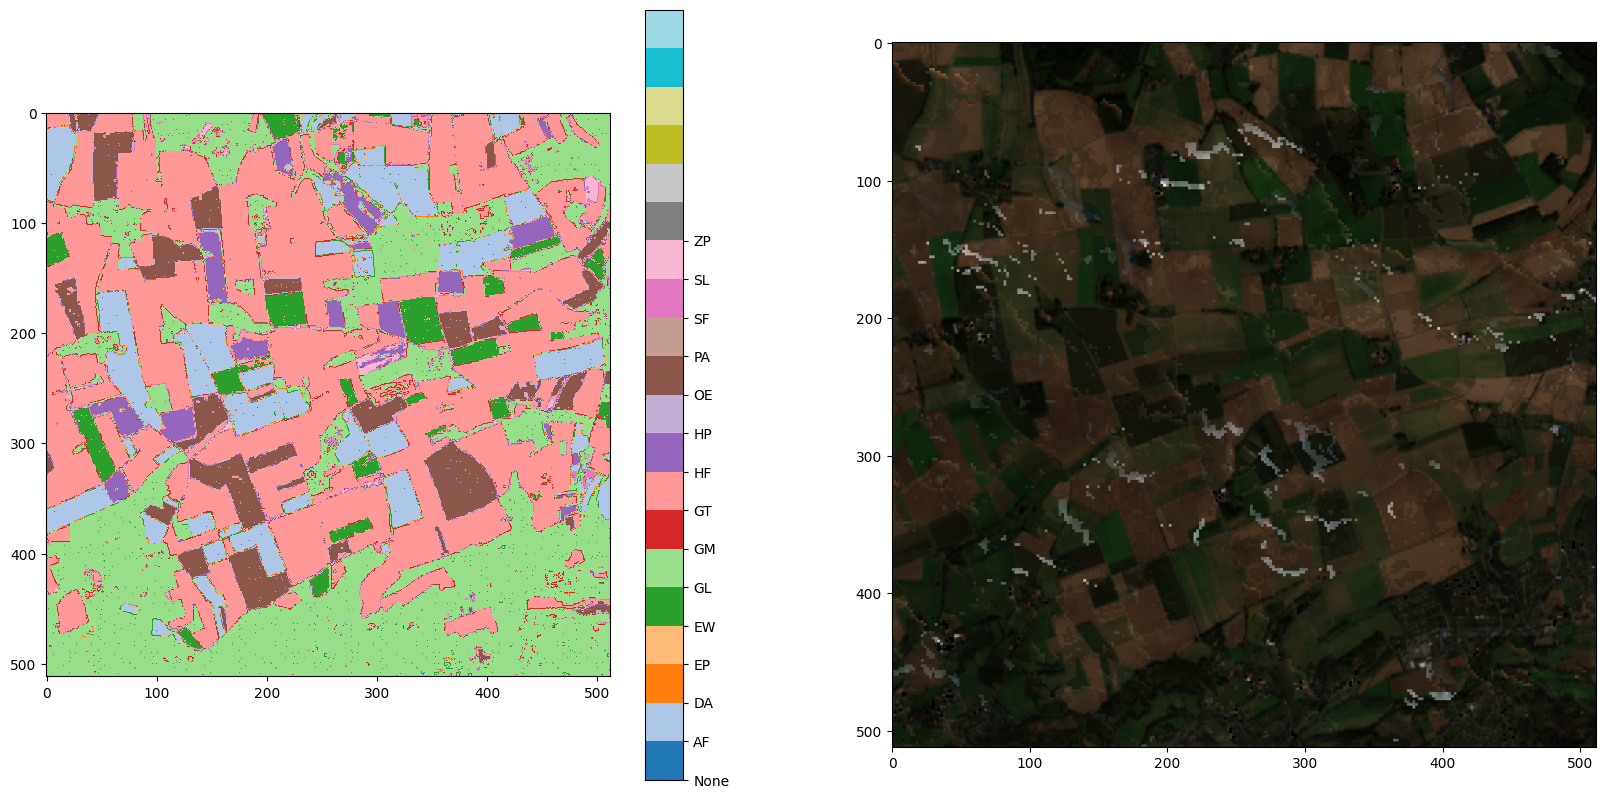

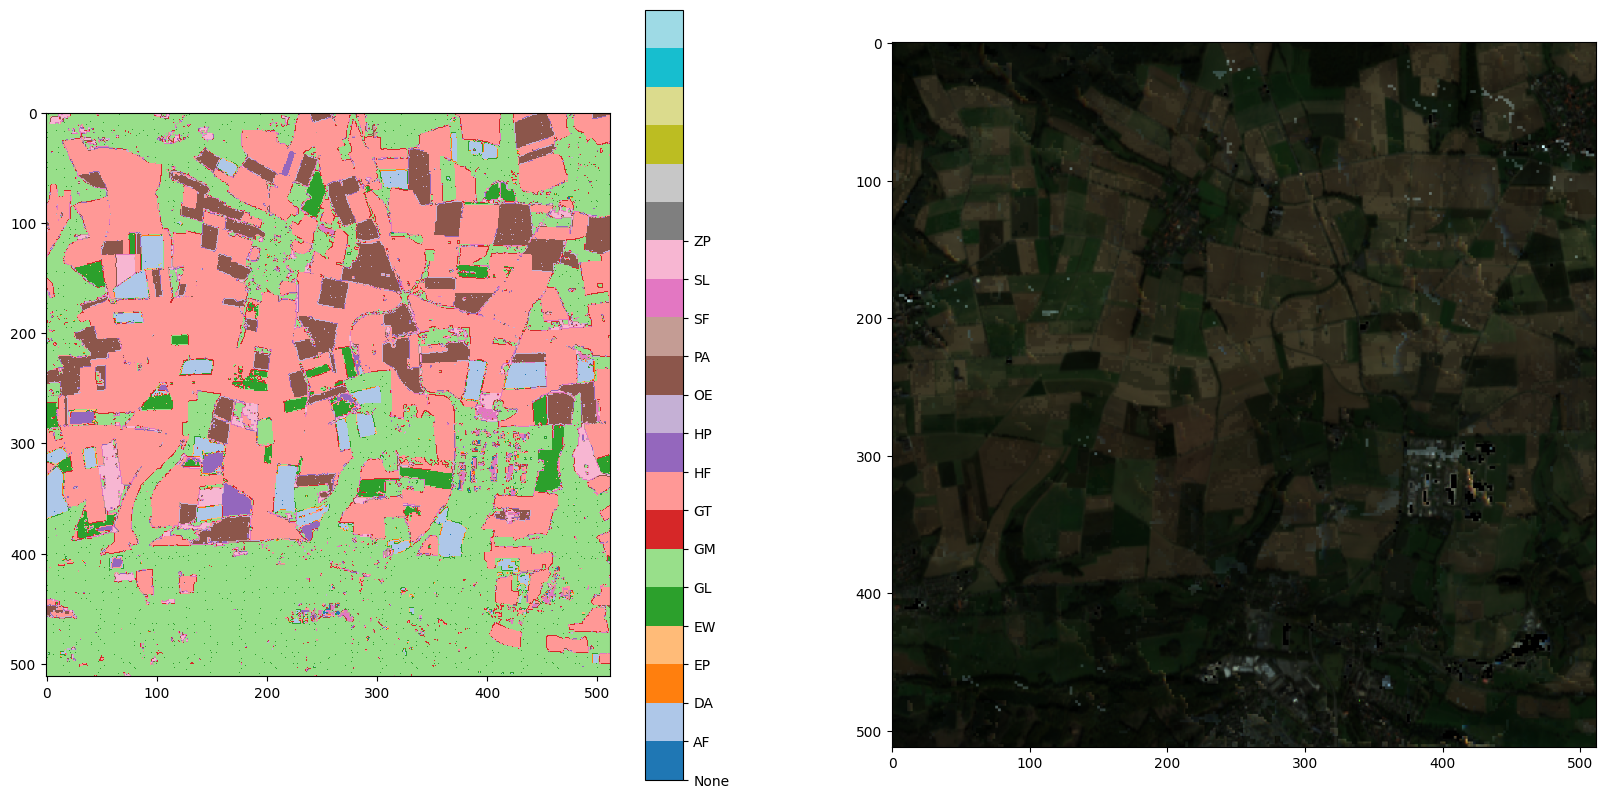

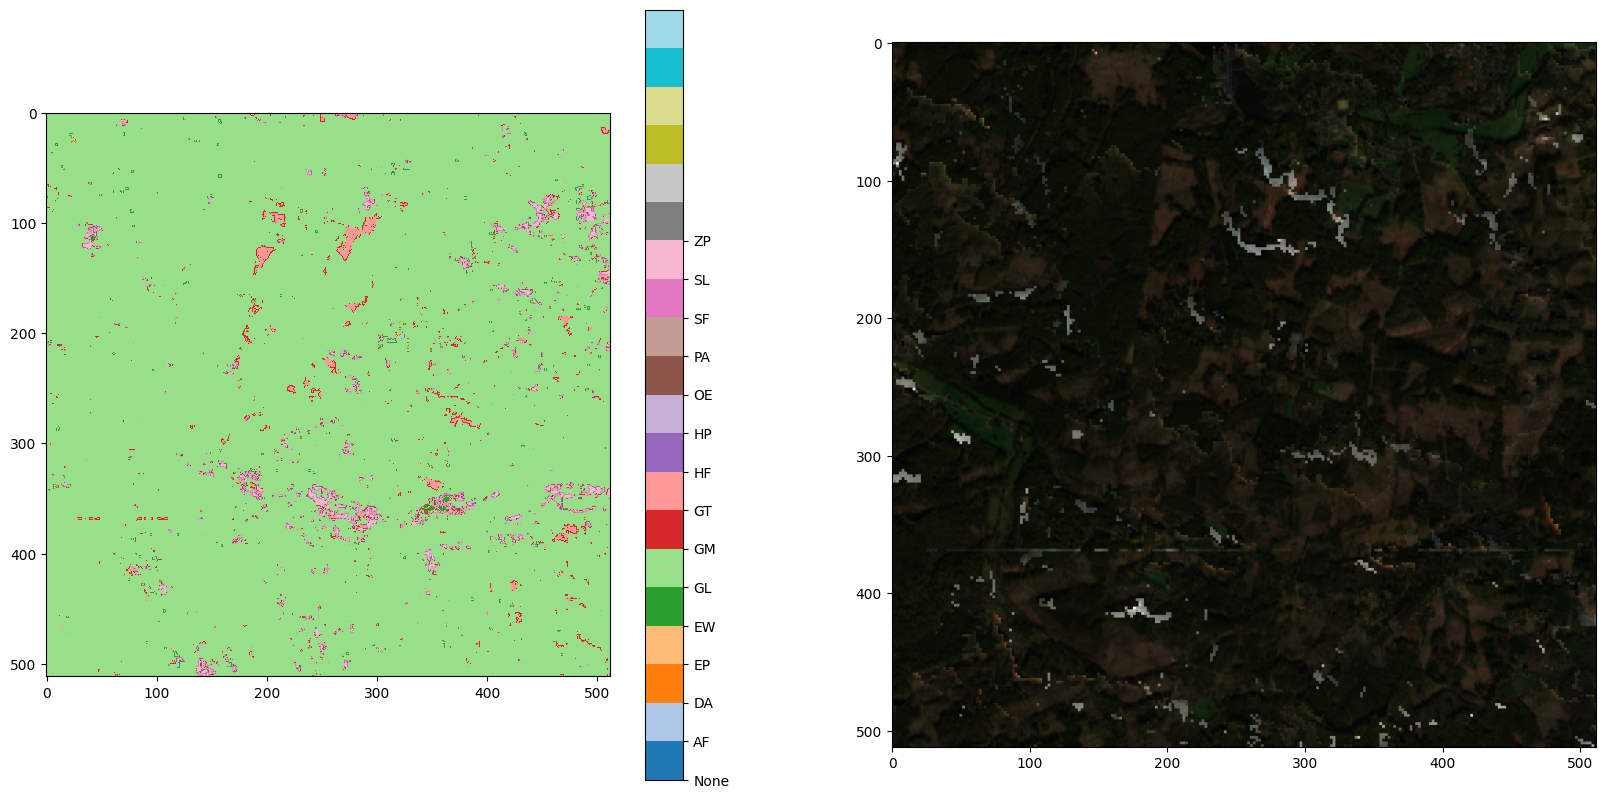

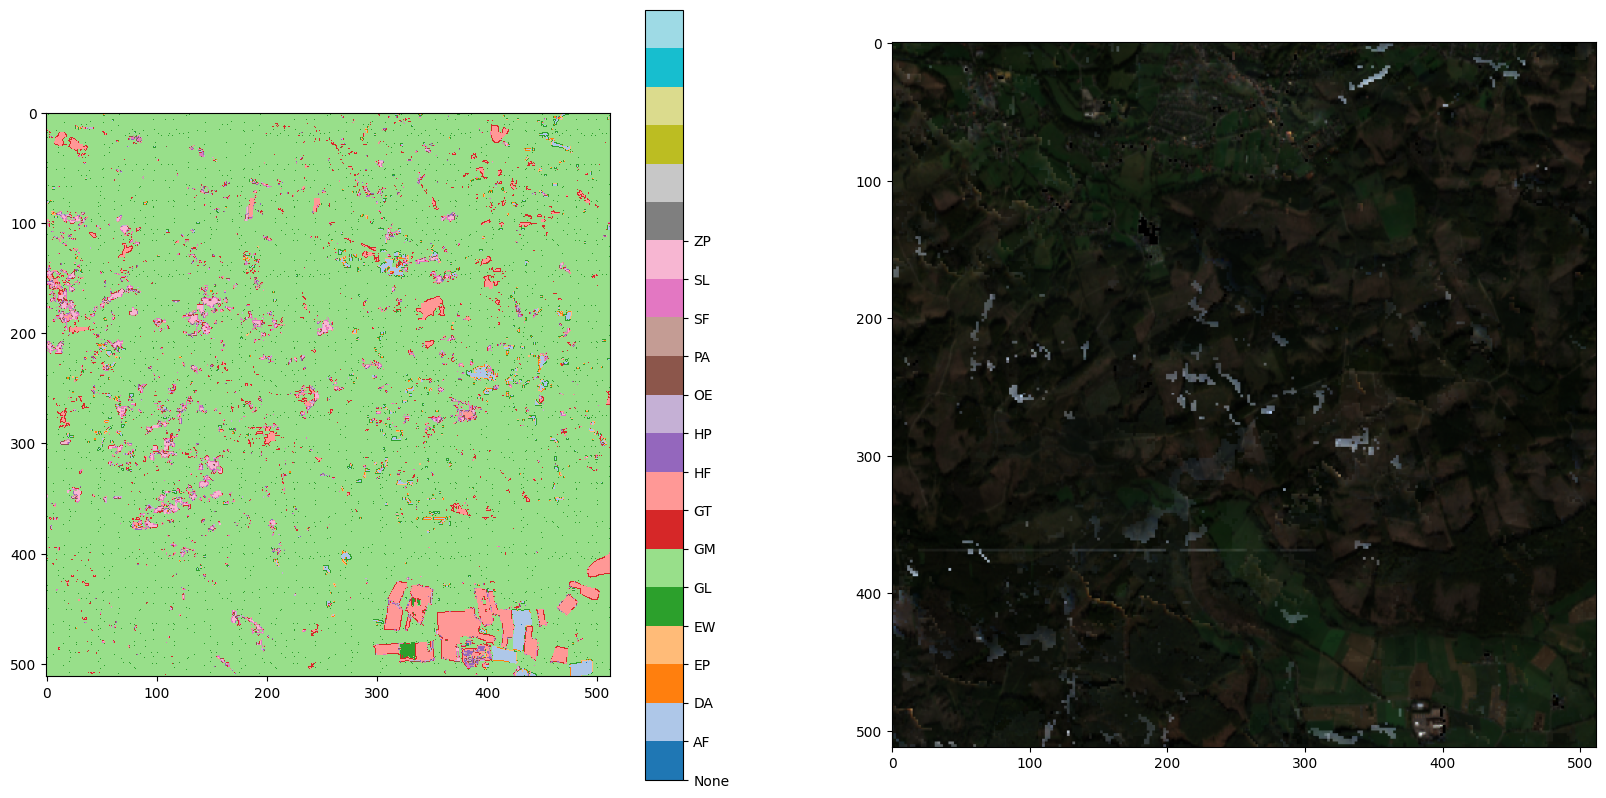

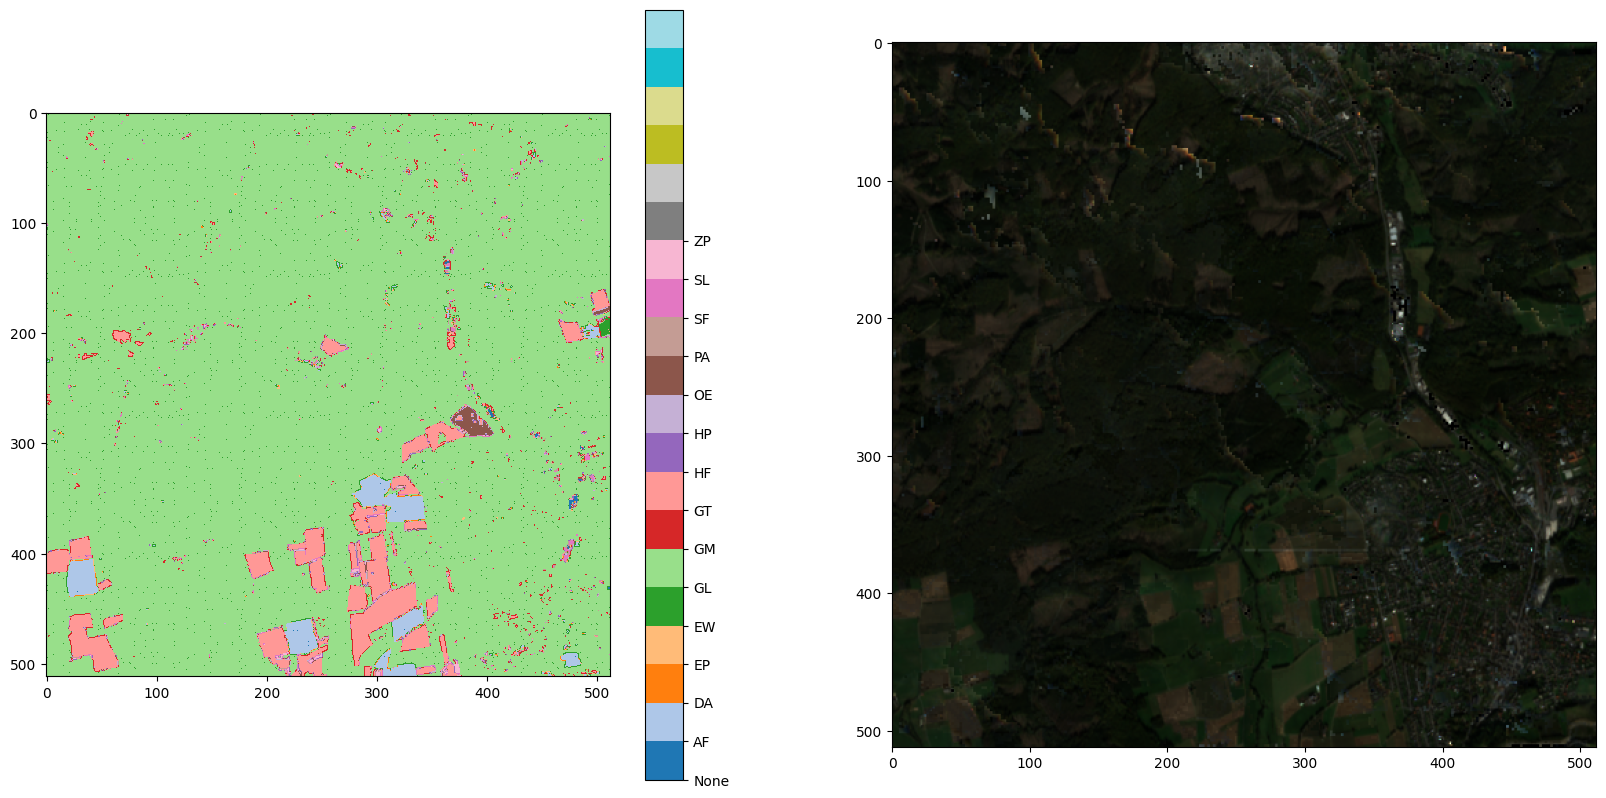

In [35]:
for (clas, rgb) in zip(res_arrays, rgb_arrays):
    fig0, (ax0, ax1) = plt.subplots(1,2, figsize=(20, 10))
    cax0 = ax0.imshow(clas, vmin=0, vmax=20, cmap="tab20")
    cbar0 = fig0.colorbar(cax0, ticks=list(code_id_map.values()))
    cbar0.ax.set_yticklabels(list(code_id_map.keys()))
    ax1.imshow(rgb)
    

In the classification map, we can see that the model is able to generate sound field shapes.
It is also visible that the model is able to distinguish between the different field-use classes.
When comparing the classification map to the NRW crop data, we can see that the model is able to predict the field-use classes for most of the fields.
There are some areas, mainly at the south border of the map, where the model predicted "Greenland (GL)".
This area is not covered by a field and therefore not labeled in the NRW crop data.
However, those areas are Greenland in OpenStreetMap and therefore the model predicted "Greenland (GL)" might be correct.
